In [71]:
from random import seed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
seed(1)

In [72]:
folder_path = '.'

train_folder = folder_path + '/train'

def get_data_for_week(week):
    week_input = pd.read_csv(f'{train_folder}/input_2023_w{week}.csv')
    week_output = pd.read_csv(f'{train_folder}/output_2023_w{week}.csv')
    return week_input, week_output

def get_sup_data():
    sup_data = pd.read_csv(folder_path + '/supplementary_data.csv')
    return sup_data


weeks = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']

sup_data = get_sup_data()

weeks_df_arr_input = []
weeks_df_arr_output = []
for week in weeks:
    week_input1, week_output1 = get_data_for_week(week)
    weeks_df_arr_input.append(week_input1)
    weeks_df_arr_output.append(week_output1)

week_input = pd.concat(weeks_df_arr_input)
week_output = pd.concat(weeks_df_arr_output)

print(f"all weeks input.shape: {week_input.shape}")
print(f"all weeks output.shape: {week_output.shape}")

def make_game_play_id(df):
    return df['game_id'].astype(str) + '_' + df['play_id'].astype(str)

sup_data['game_play_id'] = make_game_play_id(sup_data)
week_input['game_play_id'] = make_game_play_id(week_input)
week_output['game_play_id'] = make_game_play_id(week_output)

sup_data.drop(columns=['game_id'], inplace=True)
sup_data.drop(columns=['play_id'], inplace=True)

week_input.drop(columns=['game_id'], inplace=True)
week_input.drop(columns=['play_id'], inplace=True)

week_output.drop(columns=['game_id'], inplace=True)
week_output.drop(columns=['play_id'], inplace=True)

/var/folders/5w/wqg3d8mj5xbb7jj6cc1hx8vc0000gn/T/ipykernel_22710/1805156073.py:11: DtypeWarning:

Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.



all weeks input.shape: (4880579, 23)
all weeks output.shape: (562936, 6)


In [73]:
input_features = ['nfl_id', 'play_direction', 'player_name',
       'player_position', 'player_side', 'player_role', 'ball_land_x', 'ball_land_y',
       'game_play_id']

week_input = week_input[input_features]
week_input = week_input.drop_duplicates(subset=['game_play_id', 'nfl_id'])

merged = pd.merge(week_output, week_input, on=['game_play_id', 'nfl_id'], how='left')
merged.head()

print(f"merged.shape: {merged.shape}")

merged_with_sup = pd.merge(merged, sup_data, on='game_play_id', how='left')
print(f"merged_with_sup.shape: {merged_with_sup.shape}")

merged.shape: (562936, 12)
merged_with_sup.shape: (562936, 51)


In [74]:
completions = merged_with_sup[merged_with_sup['pass_result'] == 'C']
completions['yards_gained'].describe()

count    332132.00000
mean         16.24107
std          12.91178
min         -22.00000
25%           7.00000
50%          13.00000
75%          22.00000
max          92.00000
Name: yards_gained, dtype: float64

In [75]:
def calculate_first_down_features(df):
    def process_play(play_df):
        play_info = play_df.iloc[0]
        play_direction = play_info['play_direction']

        if play_info.get('pass_result') != 'C':
            return None

        yards_to_go = play_info.get('yards_to_go')
        yards_gained = play_info.get('yards_gained', 0)

        if pd.isna(yards_to_go):
            return None

        catch_x = play_info['ball_land_x']
        catch_y = play_info['ball_land_y']
        catch_frame = play_df['frame_id'].max()
        catch_moment = play_df[play_df['frame_id'] == catch_frame]

        receiver = catch_moment[catch_moment['player_role'] == 'Targeted Receiver']
        defenders = catch_moment[catch_moment['player_role'] == 'Defensive Coverage']

        if receiver.empty or defenders.empty:
            return None

        receiver = receiver.iloc[0]
        air_yards = play_info.get('pass_length', 0)

        if pd.isna(air_yards):
            return None

        if air_yards >= yards_to_go:
            return None

        yards_needed_after_catch = yards_to_go - air_yards
        converted_first_down = 1 if yards_gained >= yards_to_go else 0

        defender_distances = np.sqrt(
            (defenders['x'] - catch_x) ** 2 +
            (defenders['y'] - catch_y) ** 2
        )
        nearest_defender_distance = defender_distances.min()
        nearest_defender_idx = defender_distances.idxmin()
        nearest_defender_id = defenders.loc[nearest_defender_idx, 'nfl_id']
        nearest_defender_name = defenders.loc[nearest_defender_idx, 'player_name']
        nearest_defender_position = defenders.loc[nearest_defender_idx, 'player_position']

        defenders_within_5yds = (defender_distances <= 5).sum()
        defenders_within_3yds = (defender_distances <= 3).sum()

        receiver_tracking = play_df[play_df['player_role'] == 'Targeted Receiver'].sort_values('frame_id')
        if len(receiver_tracking) >= 2:
            last_frames = receiver_tracking.tail(2)
            dx = last_frames['x'].diff().iloc[-1]
            dy = last_frames['y'].diff().iloc[-1]
            distance = np.sqrt(dx ** 2 + dy ** 2)
            receiver_speed = distance * 10
        else:
            receiver_speed = 0

        if len(receiver_tracking) >= 2:
            last_frames = receiver_tracking.tail(2)
            dx = last_frames['x'].diff().iloc[-1]
            if play_direction == 'right':
                momentum_toward_first_down = dx
            else:
                momentum_toward_first_down = -dx
            momentum_toward_first_down = momentum_toward_first_down * 10
        else:
            momentum_toward_first_down = 0

        cushion = nearest_defender_distance

        if play_direction == 'right':
            first_down_x = catch_x + yards_needed_after_catch
        else:
            first_down_x = catch_x - yards_needed_after_catch

        if play_direction == 'right':
            defenders_blocking_first_down = ((defenders['x'] > catch_x) & (defenders['x'] < first_down_x)).sum()
        else:
            defenders_blocking_first_down = ((defenders['x'] < catch_x) & (defenders['x'] > first_down_x)).sum()

        distance_to_sideline = min(abs(catch_y - 0), abs(catch_y - 53.3))

        coverage_type = play_info.get('team_coverage_man_zone', None)
        is_man_coverage = 1 if coverage_type == 'Man' else 0

        down = play_info.get('down')
        is_third_down = 1 if down == 3 else 0
        is_fourth_down = 1 if down == 4 else 0

        nearest_defender_tracking = play_df[play_df['nfl_id'] == nearest_defender_id].sort_values('frame_id')
        if len(nearest_defender_tracking) >= 2:
            last_frames = nearest_defender_tracking.tail(2)
            dx = last_frames['x'].diff().iloc[-1]
            dy = last_frames['y'].diff().iloc[-1]
            distance = np.sqrt(dx ** 2 + dy ** 2)
            nearest_defender_speed = distance * 10
        else:
            nearest_defender_speed = 0

        yards_to_cushion_ratio = yards_needed_after_catch / (cushion + 0.1)

        return pd.Series({
            'game_play_id': play_info['game_play_id'],
            'converted_first_down': converted_first_down,
            'yards_needed_after_catch': yards_needed_after_catch,
            'nearest_defender_distance': nearest_defender_distance,
            'nearest_defender_position': nearest_defender_position,
            'nearest_defender_id': nearest_defender_id,
            'nearest_defender_name': nearest_defender_name,
            'defenders_within_3yds': defenders_within_3yds,
            'defenders_within_5yds': defenders_within_5yds,
            'receiver_speed_at_catch': receiver_speed,
            'momentum_toward_first_down': momentum_toward_first_down,
            'defenders_blocking_first_down': defenders_blocking_first_down,
            'distance_to_sideline': distance_to_sideline,
            'is_man_coverage': is_man_coverage,
            'is_third_down': is_third_down,
            'is_fourth_down': is_fourth_down,
            'nearest_defender_speed': nearest_defender_speed,
            'yards_to_cushion_ratio': yards_to_cushion_ratio,
            'air_yards': air_yards,
            'yards_to_go': yards_to_go,
            'yards_gained': yards_gained,
            'down': down,
            'play_description': play_info.get('play_description'),
            'receiver_name': play_info.get('player_name'),
        })

    features_list = []
    for play_id, play_df in df.groupby('game_play_id'):
        result = process_play(play_df)
        if result is not None:
            features_list.append(result)
    features_df = pd.DataFrame(features_list)

    if len(features_df) > 0:
        conversion_rate = features_df['converted_first_down'].mean()
        print(f"\nProcessed {len(features_df)} plays where pass was short of line to gain")
        print(f"Overall conversion rate: {conversion_rate:.1%}")

    return features_df

def train_first_down_model(features_df):
    feature_cols = [
        'yards_needed_after_catch',
        'nearest_defender_distance',
        'defenders_within_3yds',
        'defenders_within_5yds',
        'receiver_speed_at_catch',
        'momentum_toward_first_down',
        'defenders_blocking_first_down',
        'distance_to_sideline',
        'is_man_coverage',
        'is_third_down',
        'nearest_defender_speed',
        'yards_to_cushion_ratio'
    ]

    X = features_df[feature_cols].copy()
    y = features_df['converted_first_down'].copy()
    mask = X.notna().all(axis=1) & y.notna()
    X = X[mask]
    y = y[mask]

    print(f"\nTraining on {len(X)} plays")
    print(f"Positive class (converted): {y.sum()} ({y.mean():.1%})")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("Logistic Regression model to predict conversion probability:\n")

    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)
    y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_lr, target_names=['Stopped', 'Converted']))
    cm = confusion_matrix(y_test, y_pred_lr)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Stopped', 'Converted'],
                yticklabels=['Stopped', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Logistic Regression')
    plt.show()
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.3f}")
    coef_df = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': lr_model.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)
    print("\nFeature Coefficients (Log-Odds):")
    print(coef_df.to_string(index=False))

    return {
        'model': lr_model,
        'data': {
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test
        },
        'predictions': {
            'lr': y_pred_proba_lr
        },
        'coefficients': coef_df
    }

In [76]:
features = calculate_first_down_features(completions)


Processed 4977 plays where pass was short of line to gain
Overall conversion rate: 28.5%


In [77]:
def analyze_defender_performance(features_df, lr_model, feature_cols, min_plays=5):

    if 'nearest_defender_id' not in features_df.columns:
        return None

    X = features_df[feature_cols].copy()
    mask = X.notna().all(axis=1)
    X_clean = X[mask]
    features_clean = features_df[mask].copy()

    conversion_probs = lr_model.predict_proba(X_clean)[:, 1]
    features_clean['conversion_probability'] = conversion_probs

    # Aggregate by defender
    defender_stats = features_clean.groupby('nearest_defender_name').agg({
        'conversion_probability': ['mean', 'count'],
        'converted_first_down': 'mean'
    }).reset_index()

    defender_stats.columns = ['defender_name', 'avg_conversion_prob', 'num_plays', 'actual_conversion_rate']
    defender_stats = defender_stats[defender_stats['num_plays'] >= min_plays].copy()
    defender_stats = defender_stats.sort_values('avg_conversion_prob')

    best_10 = defender_stats.head(10).copy()
    worst_10 = defender_stats.tail(10).copy()

    combined = pd.concat([best_10, worst_10])
    combined['category'] = ['Best Defenders'] * 10 + ['Worst Defenders'] * 10

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Bar plot for best defenders
    ax1 = axes[0]
    best_10_sorted = best_10.sort_values('avg_conversion_prob', ascending=False)
    ax1.barh(
        range(len(best_10_sorted)),
        best_10_sorted['avg_conversion_prob'],
        color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5
    )
    ax1.set_yticks(range(len(best_10_sorted)))
    ax1.set_yticklabels([f"{name}\n({int(plays)} plays)" 
                         for name, plays in zip(best_10_sorted['defender_name'], best_10_sorted['num_plays'])],
                        fontsize=10)
    ax1.set_xlabel('Average Conversion Probability Allowed', fontsize=12, fontweight='bold')
    ax1.set_title('TOP 10 BEST DEFENDERS\n(Lowest Conversion Probability Allowed)', 
                  fontsize=14, fontweight='bold', color='#27ae60')
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.set_xlim(0, max(combined['avg_conversion_prob']) * 1.1)
    for i, (idx, row) in enumerate(best_10_sorted.iterrows()):
        ax1.text(row['avg_conversion_prob'] + 0.01, i, 
                 f"{row['avg_conversion_prob']:.1%}", 
                 va='center', fontsize=9, fontweight='bold')

    # Bar plot for worst defenders
    ax2 = axes[1]
    worst_10_sorted = worst_10.sort_values('avg_conversion_prob', ascending=True)
    ax2.barh(
        range(len(worst_10_sorted)),
        worst_10_sorted['avg_conversion_prob'],
        color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5
    )
    ax2.set_yticks(range(len(worst_10_sorted)))
    ax2.set_yticklabels([f"{name}\n({int(plays)} plays)" 
                         for name, plays in zip(worst_10_sorted['defender_name'], worst_10_sorted['num_plays'])],
                        fontsize=10)
    ax2.set_xlabel('Average Conversion Probability Allowed', fontsize=12, fontweight='bold')
    ax2.set_title('TOP 10 WORST DEFENDERS\n(Highest Conversion Probability Allowed)', 
                  fontsize=14, fontweight='bold', color='#c0392b')
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.set_xlim(0, max(combined['avg_conversion_prob']) * 1.1)
    for i, (idx, row) in enumerate(worst_10_sorted.iterrows()):
        ax2.text(row['avg_conversion_prob'] + 0.01, i, 
                 f"{row['avg_conversion_prob']:.1%}", 
                 va='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return {
        'best_defenders': best_10_sorted,
        'worst_defenders': worst_10_sorted,
        'all_defenders': defender_stats
    }


Training on 4977 plays
Positive class (converted): 1416 (28.5%)
Logistic Regression model to predict conversion probability:


Classification Report:
              precision    recall  f1-score   support

     Stopped       0.81      0.93      0.87       713
   Converted       0.73      0.47      0.57       283

    accuracy                           0.80       996
   macro avg       0.77      0.70      0.72       996
weighted avg       0.79      0.80      0.78       996



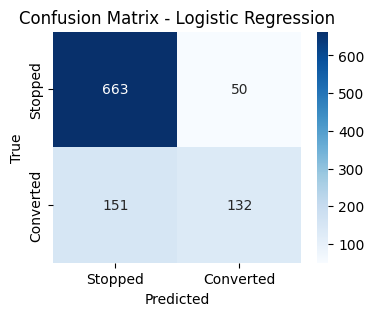

ROC AUC Score: 0.822

Feature Coefficients (Log-Odds):
                      feature  coefficient
   momentum_toward_first_down     0.374167
     yards_needed_after_catch    -0.307823
        defenders_within_5yds    -0.199174
    nearest_defender_distance     0.184012
defenders_blocking_first_down    -0.170766
        defenders_within_3yds    -0.146393
      receiver_speed_at_catch     0.127244
                is_third_down     0.095196
       yards_to_cushion_ratio    -0.079349
       nearest_defender_speed    -0.026302
         distance_to_sideline     0.012599
              is_man_coverage     0.000000


In [78]:
results = train_first_down_model(features)

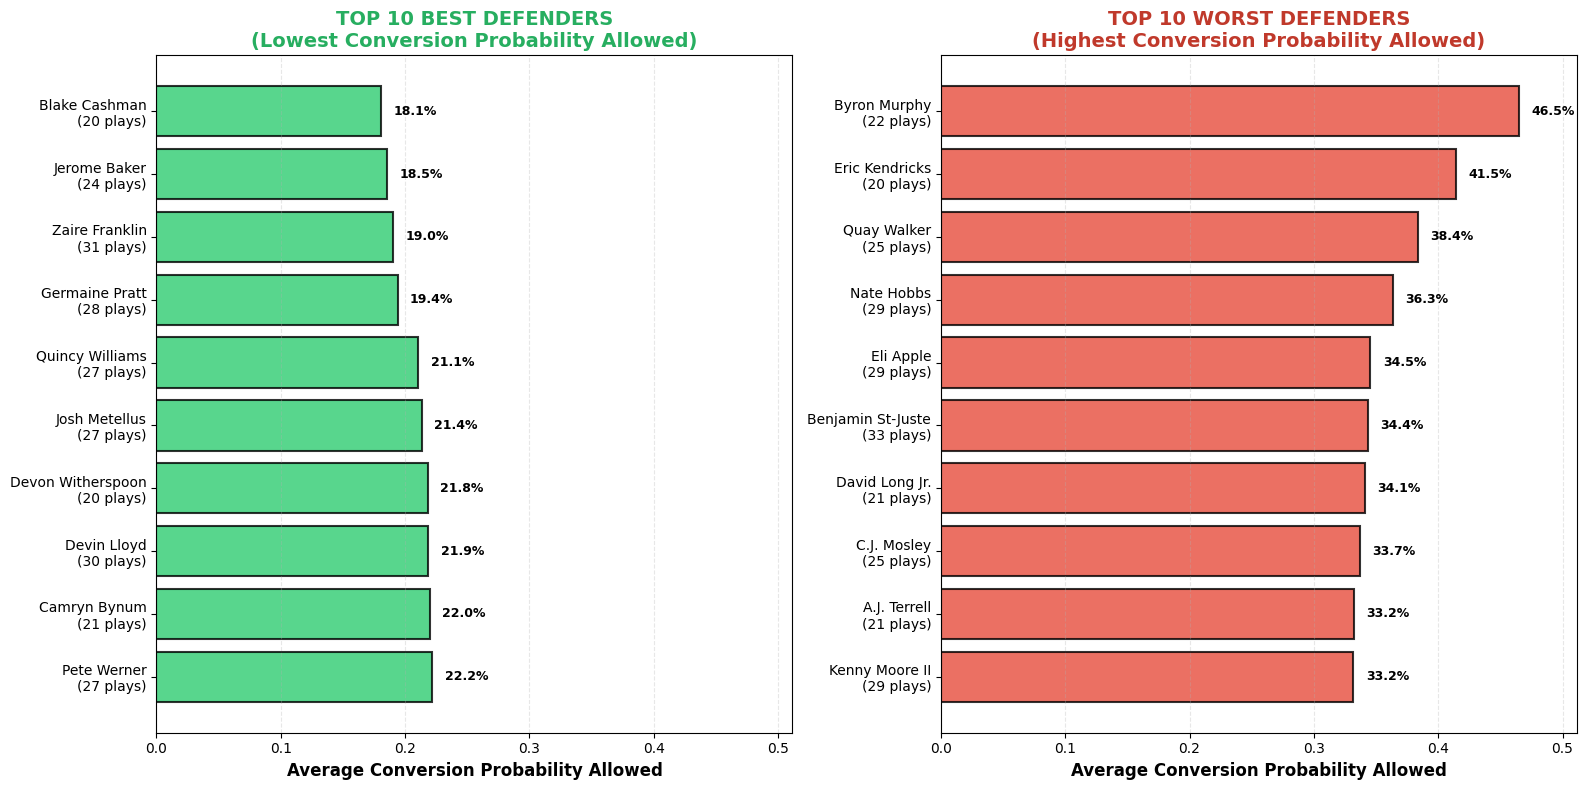

In [79]:
lr_model = results['model']
feature_cols = [
    'yards_needed_after_catch', 'nearest_defender_distance',
    'defenders_within_3yds', 'defenders_within_5yds',
    'receiver_speed_at_catch', 'momentum_toward_first_down',
    'defenders_blocking_first_down', 'distance_to_sideline',
    'is_man_coverage', 'is_third_down',
    'nearest_defender_speed', 'yards_to_cushion_ratio'
]

# Analyze defender performance
defender_analysis = analyze_defender_performance(
    features_df=features,
    lr_model=lr_model,
    feature_cols=feature_cols,
    min_plays=20
)

In [80]:
from typing import List

def get_play_openness_metrics(play_data: pd.DataFrame, receiver_role: str, defender_role: str):

    first_row = play_data.iloc[0]
    metrics = {
        'game_play_id': first_row['game_play_id'],
        'nearest_defender_id': None,
        'openness_delta': np.nan,
        'play_pass_result': first_row['pass_result'],
        'play_season': first_row['season'],
        'play_week': first_row['week'],
        'defensive_team': first_row['defensive_team'],
        'defender_name': None,
        'defender_position': None,
        'pct_separation_closed': np.nan
    }
    
    receiver_data = play_data[play_data['player_role'] == receiver_role]
    defender_data = play_data[play_data['player_role'] == defender_role]

    if receiver_data.empty or defender_data.empty or receiver_data.shape[0] < 2:
        return metrics

    openness_list = []
    final_frame = receiver_data['frame_id'].max()
    
    for frame in receiver_data['frame_id'].unique():
        rec_pos = receiver_data[receiver_data['frame_id'] == frame][['x', 'y']].values
        def_pos_df = defender_data[defender_data['frame_id'] == frame]
        if rec_pos.size > 0 and not def_pos_df.empty:
            rec_x, rec_y = rec_pos[0]
            distances = np.sqrt(
                (def_pos_df['x'].values - rec_x)**2 + 
                (def_pos_df['y'].values - rec_y)**2
            )
            min_distance = np.min(distances)
            openness_list.append(min_distance)
            if frame == final_frame:
                nearest_defender_row = def_pos_df.iloc[np.argmin(distances)]
                metrics['nearest_defender_id'] = nearest_defender_row['nfl_id']
                metrics['defender_name'] = nearest_defender_row['player_name']
                metrics['defender_position'] = nearest_defender_row['player_position']

    if not openness_list:
        return metrics

    max_openness = np.max(openness_list)
    arrival_openness = openness_list[-1]
    metrics['openness_delta'] = max_openness - arrival_openness

    if max_openness > 0:
        metrics['pct_separation_closed'] = (metrics['openness_delta'] / max_openness) * 100
    else:
        metrics['pct_separation_closed'] = np.nan
    
    return metrics


def calculate_all_openness_deltas(df: pd.DataFrame, receiver_role: str = 'Targeted Receiver', defender_role: str = 'Defensive Coverage') -> pd.DataFrame:

    unique_plays = df['game_play_id'].unique()
    all_metrics = []
    for play_id in unique_plays:
        play_data = df[df['game_play_id'] == play_id].copy()
        metrics = get_play_openness_metrics(play_data, receiver_role, defender_role)
        if metrics['nearest_defender_id'] is not None and not np.isnan(metrics['openness_delta']):
            all_metrics.append(metrics)
    if not all_metrics:
        return pd.DataFrame()
    return pd.DataFrame(all_metrics)


def plot_defender_openness_ranking(
    metrics_df: pd.DataFrame, 
    groupby_cols: List[str] = ['nearest_defender_id', 'defender_name']
):

    if metrics_df.empty:
        print("Metrics DataFrame is empty.")
        return

    if len(groupby_cols) > 1:
        metrics_df['plot_label'] = metrics_df[groupby_cols].apply(
            lambda row: ' | '.join(row.values.astype(str)), axis=1
        )
        label_col = 'plot_label'
    else:
        label_col = groupby_cols[0]

    defender_summary = metrics_df.groupby(groupby_cols).agg({
        'openness_delta': 'mean',
        'pct_separation_closed': 'mean'
    }).reset_index()
    defender_summary.rename(columns={
        'openness_delta': 'mean_openness_delta',
        'pct_separation_closed': 'mean_pct_separation_closed'
    }, inplace=True)
    if len(groupby_cols) > 1:
        label_map = metrics_df[[*groupby_cols, label_col]].drop_duplicates() \
                                                          .set_index(groupby_cols)[label_col]
        defender_summary[label_col] = defender_summary.set_index(groupby_cols).index.map(label_map)
    plot_df_full = defender_summary.dropna(subset=[label_col])

    def make_plot(df, metric_col, title, xlabel, use_percent=False):
        if df.shape[0] < 20:
            N = df.shape[0] // 2
            top_n = df.sort_values(metric_col, ascending=False).head(N)
            bottom_n = df.sort_values(metric_col, ascending=False).tail(N)
            plot_df = pd.concat([top_n, bottom_n]).drop_duplicates()
        else:
            top_10 = df.sort_values(metric_col, ascending=False).head(10)
            bottom_10 = df.sort_values(metric_col, ascending=False).tail(10)
            plot_df = pd.concat([top_10, bottom_10])
        plot_df['color'] = np.where(plot_df[metric_col] > 0, '#38A169', '#E53E3E')
        plt.figure(figsize=(12, 8))
        plot_df = plot_df.sort_values(metric_col, ascending=True)
        bars = plt.barh(plot_df[label_col], plot_df[metric_col], color=plot_df['color'])
        plt.axvline(0, color='gray', linestyle='--', linewidth=1)
        for bar in bars:
            width = bar.get_width()
            label_value = f'{width:.1f}%' if use_percent else f'{width:.2f}'
            label_x_pos = width + 1 if width > 0 else width - 5  
            plt.text(label_x_pos, bar.get_y() + bar.get_height()/2,
                     label_value, ha='center', va='center', fontsize=9)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(groupby_cols[0], fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    make_plot(
        plot_df_full,
        metric_col='mean_openness_delta',
        title=f"Top/Worst Closers by Mean Openness Delta Grouped by: {', '.join(groupby_cols)}",
        xlabel="Mean Openness Delta (Yards Closed After Peak)",
        use_percent=False
    )
    make_plot(
        plot_df_full,
        metric_col='mean_pct_separation_closed',
        title=f"Top/Worst Closers by % Separation Closed Grouped by: {', '.join(groupby_cols)}",
        xlabel="Mean Percentage of Separation Closed (%)",
        use_percent=True
    )

In [81]:
openness_metrics = calculate_all_openness_deltas(completions)

In [82]:
def calculate_defender_closing_impact(
    features_df: pd.DataFrame,
    openness_metrics_df: pd.DataFrame,
    lr_model: LogisticRegression,
    feature_cols: list,
    min_plays: int = 10
):

    combined_df = features_df.merge(
        openness_metrics_df[['game_play_id', 'nearest_defender_id', 'openness_delta', 
                              'pct_separation_closed', 'defender_position']],
        on=['game_play_id', 'nearest_defender_id'],
        how='inner'
    )

    X = combined_df[feature_cols].copy()
    mask = X.notna().all(axis=1) & combined_df['openness_delta'].notna()
    X_clean = X[mask]
    combined_clean = combined_df[mask].copy()
    baseline_probs = lr_model.predict_proba(X_clean)[:, 1]
    combined_clean['baseline_conversion_prob'] = baseline_probs

    # Position-level averages
    position_avg = combined_clean.groupby('defender_position').agg({
        'openness_delta': 'mean',
        'pct_separation_closed': 'mean',
        'baseline_conversion_prob': 'count'
    }).reset_index()
    position_avg.columns = ['defender_position', 'position_avg_openness_delta', 
                             'position_avg_pct_closed', 'plays']

    combined_clean = combined_clean.merge(position_avg, on='defender_position', how='left')

    # Defender stats vs positional average
    defender_stats = combined_clean.groupby(['nearest_defender_id', 'nearest_defender_name', 'defender_position']).agg({
        'openness_delta': 'mean',
        'pct_separation_closed': 'mean',
        'position_avg_openness_delta': 'first',
        'position_avg_pct_closed': 'first',
        'baseline_conversion_prob': ['mean', 'count'],
        'converted_first_down': 'mean'
    }).reset_index()
    defender_stats.columns = [
        'defender_id', 'defender_name', 'position',
        'avg_openness_delta', 'avg_pct_closed',
        'position_avg_openness_delta', 'position_avg_pct_closed',
        'avg_baseline_prob', 'num_plays', 'actual_conversion_rate'
    ]
    defender_stats = defender_stats[defender_stats['num_plays'] >= min_plays].copy()

    defender_stats['openness_delta_vs_position'] = (
        defender_stats['avg_openness_delta'] - defender_stats['position_avg_openness_delta']
    )
    defender_stats['pct_closed_vs_position'] = (
        defender_stats['avg_pct_closed'] - defender_stats['position_avg_pct_closed']
    )

    # Counterfactuals for closing ability impact
    counterfactual_data = []
    for _, defender_row in defender_stats.iterrows():
        defender_id = defender_row['defender_id']
        position = defender_row['position']
        defender_plays = combined_clean[combined_clean['nearest_defender_id'] == defender_id].copy()
        if len(defender_plays) == 0:
            continue
        position_avg_delta = defender_row['position_avg_openness_delta']
        actual_avg_delta = defender_row['avg_openness_delta']
        delta_difference = position_avg_delta - actual_avg_delta
        defender_plays_counterfactual = defender_plays.copy()
        defender_plays_counterfactual['nearest_defender_distance'] = (
            defender_plays_counterfactual['nearest_defender_distance'] + delta_difference
        )
        defender_plays_counterfactual['nearest_defender_distance'] = (
            defender_plays_counterfactual['nearest_defender_distance'].clip(lower=0)
        )
        X_counterfactual = defender_plays_counterfactual[feature_cols].copy()
        counterfactual_probs = lr_model.predict_proba(X_counterfactual)[:, 1]
        actual_probs = defender_plays['baseline_conversion_prob'].values
        prob_reduction = np.mean(actual_probs - counterfactual_probs)
        counterfactual_data.append({
            'defender_id': defender_id,
            'defender_name': defender_row['defender_name'],
            'position': position,
            'num_plays': len(defender_plays),
            'avg_actual_conv_prob': np.mean(actual_probs),
            'avg_counterfactual_conv_prob': np.mean(counterfactual_probs),
            'prob_reduction_from_closing': prob_reduction,
            'openness_delta_vs_position': defender_row['openness_delta_vs_position'],
            'pct_closed_vs_position': defender_row['pct_closed_vs_position'],
            'actual_conversion_rate': defender_row['actual_conversion_rate']
        })
    impact_df = pd.DataFrame(counterfactual_data)
    impact_df = impact_df.sort_values('prob_reduction_from_closing', ascending=False)
    top_10 = impact_df.head(10)
    bottom_10 = impact_df.tail(10)

    # Plot: Top 10 Closers
    plt.figure(figsize=(7, 5))
    top_10_sorted = top_10.sort_values('prob_reduction_from_closing', ascending=True)
    colors1 = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_10_sorted['prob_reduction_from_closing']]
    plt.barh(
        range(len(top_10_sorted)), 
        top_10_sorted['prob_reduction_from_closing'] * 100,
        color=colors1, alpha=0.8, edgecolor='black', linewidth=1.5
    )
    plt.yticks(
        range(len(top_10_sorted)),
        [f"{name} ({pos})" for name, pos in zip(
            top_10_sorted['defender_name'], top_10_sorted['position']
        )],
        fontsize=8
    )
    plt.xlabel('Conversion Probability Reduced by Closing (%)', fontsize=10, fontweight='bold')
    plt.title('Top 10 Closers (Greatest Reduction in Conversion Probability)', fontsize=11, fontweight='bold', color='#27ae60')
    plt.axvline(0, color='black', linestyle='-', linewidth=1)
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    for i, (idx, row) in enumerate(top_10_sorted.iterrows()):
        plt.text(
            row['prob_reduction_from_closing'] * 100 - 0.3,
            i,
            f"{row['prob_reduction_from_closing']*100:.2f}%", 
            va='center', fontsize=7, fontweight='bold'
        )
    plt.tight_layout()
    plt.show()

    # Plot: Bottom 10 Closers
    plt.figure(figsize=(7, 5))
    bottom_10_sorted = bottom_10.sort_values('prob_reduction_from_closing', ascending=False)
    colors2 = ['#2ecc71' if x > 0 else '#e74c3c' for x in bottom_10_sorted['prob_reduction_from_closing']]
    plt.barh(
        range(len(bottom_10_sorted)), 
        bottom_10_sorted['prob_reduction_from_closing'] * 100,
        color=colors2, alpha=0.8, edgecolor='black', linewidth=1.5
    )
    plt.yticks(
        range(len(bottom_10_sorted)),
        [f"{name} ({pos})" for name, pos in zip(
            bottom_10_sorted['defender_name'], bottom_10_sorted['position']
        )],
        fontsize=8
    )
    plt.xlabel('Conversion Probability Reduced by Closing (%)', fontsize=10, fontweight='bold')
    plt.title('Bottom 10 Closers (Lowest Reduction in Conversion Probability)', fontsize=11, fontweight='bold', color='#c0392b')
    plt.axvline(0, color='black', linestyle='-', linewidth=1)
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    for i, (idx, row) in enumerate(bottom_10_sorted.iterrows()):
        plt.text(
            row['prob_reduction_from_closing'] * 100 + 0.3,
            i,
            f"{row['prob_reduction_from_closing']*100:.2f}%", 
            va='center', fontsize=7, fontweight='bold'
        )
    plt.tight_layout()
    plt.show()

    # Plot: Top 10 by Closing vs Positional Average
    plt.figure(figsize=(7, 5))
    top_10_closing = impact_df.nlargest(10, 'openness_delta_vs_position')
    top_10_closing_sorted = top_10_closing.sort_values('openness_delta_vs_position', ascending=True)
    colors1 = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_10_closing_sorted['openness_delta_vs_position']]
    plt.barh(
        range(len(top_10_closing_sorted)),
        top_10_closing_sorted['openness_delta_vs_position'],
        color=colors1, alpha=0.8, edgecolor='black', linewidth=1.5
    )
    plt.yticks(
        range(len(top_10_closing_sorted)),
        [f"{name} ({pos})" for name, pos in zip(
            top_10_closing_sorted['defender_name'], top_10_closing_sorted['position']
        )],
        fontsize=8
    )
    plt.xlabel('Openness Delta vs Position Avg (yards)', fontsize=10, fontweight='bold')
    plt.title('Top 10: Most Separation Closed vs Position Avg', fontsize=11, fontweight='bold', color='#27ae60')
    plt.axvline(0, color='black', linestyle='-', linewidth=1)
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    for i, (idx, row) in enumerate(top_10_closing_sorted.iterrows()):
        plt.text(
            row['openness_delta_vs_position'] - 0.2,
            i,
            f"{row['openness_delta_vs_position']:.2f} yds", 
            va='center', fontsize=7, fontweight='bold'
        )
    plt.tight_layout()
    plt.show()

    # Plot: Bottom 10 by Closing vs Positional Average
    plt.figure(figsize=(7, 5))
    bottom_10_closing = impact_df.nsmallest(10, 'openness_delta_vs_position')
    bottom_10_closing_sorted = bottom_10_closing.sort_values('openness_delta_vs_position', ascending=False)
    colors2 = ['#2ecc71' if x > 0 else '#e74c3c' for x in bottom_10_closing_sorted['openness_delta_vs_position']]
    plt.barh(
        range(len(bottom_10_closing_sorted)),
        bottom_10_closing_sorted['openness_delta_vs_position'],
        color=colors2, alpha=0.8, edgecolor='black', linewidth=1.5
    )
    plt.yticks(
        range(len(bottom_10_closing_sorted)),
        [f"{name} ({pos})" for name, pos in zip(
            bottom_10_closing_sorted['defender_name'], bottom_10_closing_sorted['position']
        )],
        fontsize=8
    )
    plt.xlabel('Openness Delta vs Position Avg (yards)', fontsize=10, fontweight='bold')
    plt.title('Bottom 10: Least Separation Closed vs Position Avg', fontsize=11, fontweight='bold', color='#c0392b')
    plt.axvline(0, color='black', linestyle='-', linewidth=1)
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    for i, (idx, row) in enumerate(bottom_10_closing_sorted.iterrows()):
        plt.text(
            row['openness_delta_vs_position'] + 0.2,
            i,
            f"{row['openness_delta_vs_position']:.2f} yds", 
            va='center', fontsize=7, fontweight='bold'
        )
    plt.tight_layout()
    plt.show()

    # Scatter: Closing Ability vs Probability Impact
    plt.figure(figsize=(9, 6))
    positions = impact_df['position'].unique()
    colors = plt.cm.Set1(np.linspace(0, 1, len(positions)))
    position_colors = dict(zip(positions, colors))
    for position in positions:
        subset = impact_df[impact_df['position'] == position]
        plt.scatter(subset['openness_delta_vs_position'], 
                   subset['prob_reduction_from_closing'] * 100,
                   label=position, 
                   alpha=0.6, 
                   s=100,
                   color=position_colors[position],
                   edgecolors='black',
                   linewidth=1)
    from sklearn.linear_model import LinearRegression
    all_x = impact_df['openness_delta_vs_position'].values
    all_y = (impact_df['prob_reduction_from_closing'] * 100).values
    reg = LinearRegression().fit(all_x.reshape(-1, 1), all_y)
    x_vals = np.linspace(all_x.min(), all_x.max(), 200)
    y_pred = reg.predict(x_vals.reshape(-1, 1))
    plt.plot(x_vals, y_pred, color='navy', linestyle='-', linewidth=2, label='Regression Line')
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.axvline(0, color='black', linestyle='--', alpha=0.3)
    plt.xlabel('Separation gap closed vs Pos(avg) (yards)', fontsize=12, fontweight='bold')
    plt.ylabel('Conversion Prob. Reduced by Closing (%)', fontsize=12, fontweight='bold')
    plt.title('Closing Ability vs Conversion Prob. Impact', fontsize=14, fontweight='bold')
    plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    # Simple summary statistics printout
    print("Top 10 defenders (conv prob reduction):")
    print(top_10[['defender_name', 'position', 'num_plays', 'openness_delta_vs_position', 
                  'prob_reduction_from_closing', 'actual_conversion_rate']].to_string(index=False))
    print("\nBottom 10 defenders (conv prob reduction):")
    print(bottom_10[['defender_name', 'position', 'num_plays', 'openness_delta_vs_position', 
                     'prob_reduction_from_closing', 'actual_conversion_rate']].to_string(index=False))
    best = top_10.iloc[0]
    worst = bottom_10.iloc[-1]
    print(f"\nBest closer: {best['defender_name']} ({best['position']}) | Impact: {best['prob_reduction_from_closing']*100:.2f}% | +{best['openness_delta_vs_position']:.2f} yds over avg")
    print(f"Worst closer: {worst['defender_name']} ({worst['position']}) | Impact: {worst['prob_reduction_from_closing']*100:.2f}% | {worst['openness_delta_vs_position']:.2f} yds vs avg")
    avg_impact = impact_df['prob_reduction_from_closing'].mean() * 100
    print(f"\nMean impact of closing ability: {avg_impact:.2f}% conv prob reduction")

    return {
        'impact_df': impact_df,
        'top_closers': top_10,
        'worst_closers': bottom_10,
        'position_averages': position_avg
    }

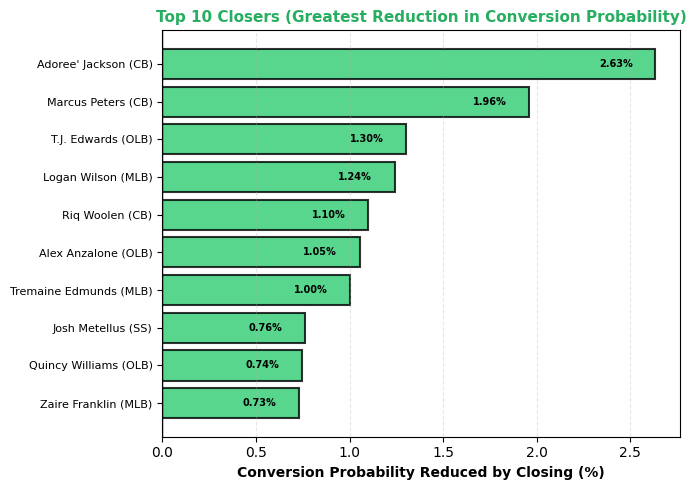

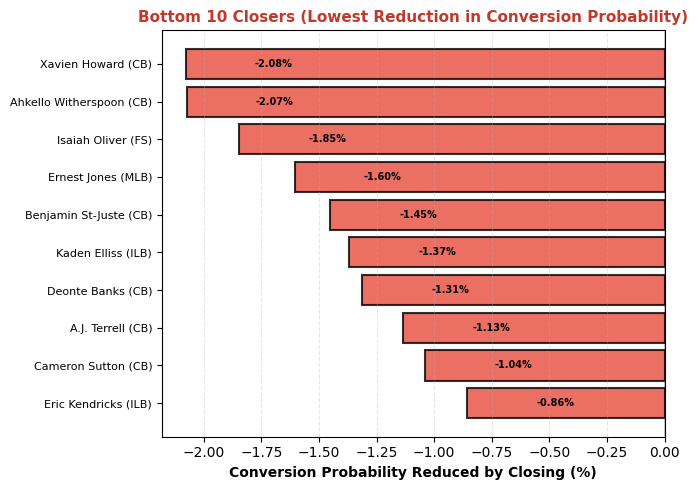

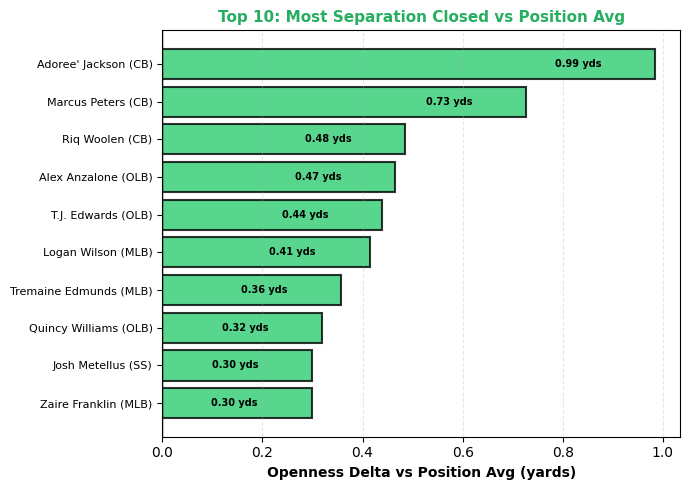

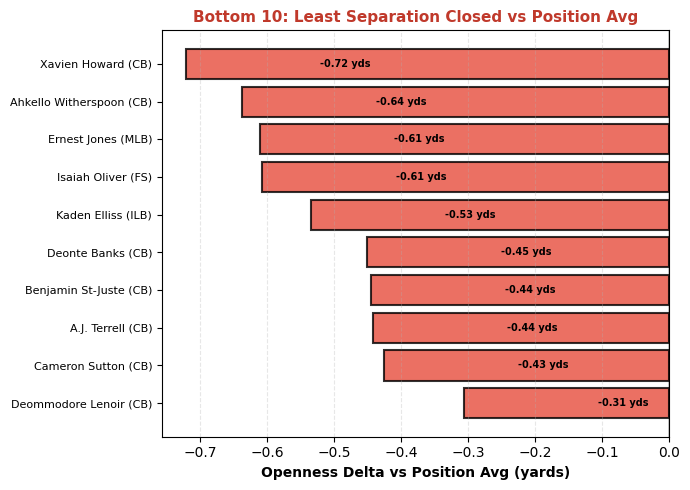

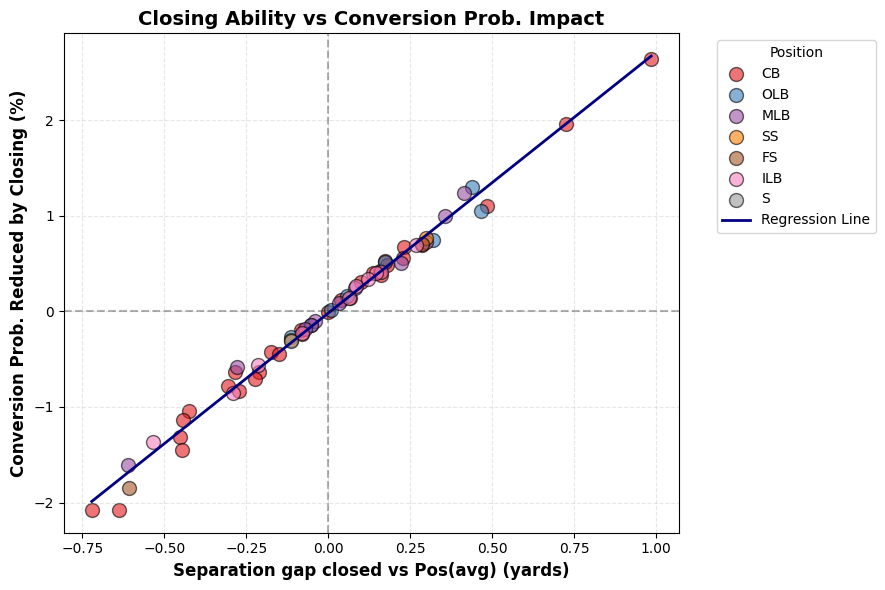

Top 10 defenders (conv prob reduction):
   defender_name position  num_plays  openness_delta_vs_position  prob_reduction_from_closing  actual_conversion_rate
 Adoree' Jackson       CB         22                    0.985040                     0.026338                0.409091
   Marcus Peters       CB         22                    0.726208                     0.019611                0.272727
    T.J. Edwards      OLB         32                    0.438934                     0.012999                0.218750
    Logan Wilson      MLB         25                    0.413909                     0.012407                0.360000
      Riq Woolen       CB         23                    0.484471                     0.010998                0.217391
   Alex Anzalone      OLB         30                    0.465741                     0.010534                0.300000
Tremaine Edmunds      MLB         22                    0.356405                     0.010023                0.272727
   Josh Metellus

In [83]:
impact_results = calculate_defender_closing_impact(
    features_df=features,
    openness_metrics_df=openness_metrics,
    lr_model=lr_model,
    feature_cols=feature_cols,
    min_plays=20
)